# CARMENES RV CURVES SYNTHETIC DATASETS CREATION

In this notebook we create several synthetic datasets of radial velocity (RV) curves, according to the statistical distribution of the relevant parameters, as inferred from the theory or from the real CARMENES RV dataset.

The basic equation to generate the samples is:

$$x(t)=A\cos\{2\pi(\nu(t-\tau)+\delta)\}+c$$

Notice that only single pulsations are modeled for each record, i.e. only a single, fundamental tone is assumed for each record.

The datasets to be created are the following ones:
- Dataset 1: the benchmark synthetic dataset. This will be a noiseless, perfectly sampled dataset. This means having a good sampling frequency, above two times the Nyquist frequency for the minimum period to be detected.
- Dataset 2: based on dataset 1, we just apply to each sample a random noise, taken from the distribution of noise inferred from the real CARMENES RV curves dataset.
- Dataset 3: based on dataset 1, we just apply to each curve a given sampling pattern, chosen randomly among the sampling patterns extracted from the real CARMENES RV dataset.
- Dataset 4: a combination of datasets 2 and 3. This dataset will somehow mimic the real CARMENES RV curves dataset, because it incorporates both the CARMENES noise distributions and typical sampling patterns. 

All the records for all the datasets will be created in parallel, so that, for example, the sampling time values of a given record in dataset 3 will be exactly the same values for the same record in dataset 4, and both records (as well as that in dataset 3) will share the same basic, clean oscillation parameters of the record in dataset 1. Notice that noise values cannot be shared between datasets 2 and 4, as their time span will be something completely different.

A table with the datasets will be generated. The table will contain, for each record, all the basic parameters of the benchmark curve (amplitude, frequency, etc., which will be common among the four datasets for a given  record). Each record will have common sequence identifier for it (for identification purposes, with the format "DS\<i\>-RV-\<j\>"). On each dataset, the name of the files containing the generated RV curves will also be stored. The names and relative paths to these files are also stored in the dataset table for later reference. "RV-" will also be the prefix to the dateset filename.

The time series files will be stored with _".dat"_ extension, with just two columns separated by a space (correspondiong to _time_ and _value_, without headers), so that we can load them straightaway into _LSTperiod_. Later we will adapt the format as required for feature extraction with the proper time series analysis package (_cesium_, _tsflex_, etc.)

## Modules and configuration

### Modules

In [1]:
import math
import pandas as pd
import numpy as np

import json

from distfit import distfit

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [2]:
# CONFIGURATION:
MODE = "NEW" # 'NEW' to overwrite the existing datasets / 'APPEND' to add records to the datasets
N = 1000 # Number of records (i.e. RV curves) to create / add.
RANDOM_STATE = 11 # For reproducibility

NON_PULSATION_FRACTION = 0.20 # Fraction of non-pulsating stars

IMAGE_FOLDER = "./img/"

DIST_SUMMARY_FILE = "./DIST_FILES/Parameter_distributions_All_GTO.csv"
DIST_FILES_FOLDER = "./DIST_FILES/"
RV_PATTERNS_FILE = "./DIST_FILES/RV_All_GTO_sampling_patterns.csv"

DATASETS_FOLDER = "./RV_DATASETS/"
DATASETS_SUMMARY_FILE = "./RV_DATASETS/RV_All_GTO_SyntheticDatasets.csv"
DS1_FOLDER = "./RV_DATASETS/DS1_ts_files/"
DS2_FOLDER = "./RV_DATASETS/DS2_ts_files/"
DS3_FOLDER = "./RV_DATASETS/DS3_ts_files/"
DS4_FOLDER = "./RV_DATASETS/DS4_ts_files/"

DSET_PREFIX="RV-" # RECOMMENDED - DO NOT CHANGE


### Functions

In [3]:
def sample_value(t, f, A, c, tau, delta, noise):
    '''Returns the value of a benchmark sample at a time 't', depending on the values of the paremeters passed:
    f: frequency; A: amplitude; c: offset; tau:reference epoch; delta:phase'''
    value = A * np.cos(2 * np.pi * (f * (t - tau) + delta)) + c + noise
    return value

In [4]:
np.pi

3.141592653589793

In [5]:
# We vectorize the previous function to be able to pass arrays as parameters,
# in order to calculate the time series in one call
v_sample_value = np.vectorize(sample_value)

## Prepare distributions of parameters

### Read configuration file

Read the file containing the distributions and values used for dataset generation.

In [6]:
dist_params = pd.read_csv(DIST_SUMMARY_FILE, sep=',', decimal='.')
dist_params.head()

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0025},NaN
1,BENCHMARK,Tobs,{'fixed_value': 0.25},NaN
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_All_GTO_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_All_GTO_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_All_GTO_dist.pickle


In [7]:
dist_params.dtypes

Group           object
Variable        object
Distribution    object
Dist_file       object
dtype: object

### Register the distributions to use for each variable

In [8]:
# Initialise variable:
param_ranges = {}
for i in range(0,len(dist_params)):
    try:
        # If successful, it is a fixed value:
        d = json.loads(dist_params.loc[i, 'Distribution'].replace('\'', '\"'))
        param_ranges[dist_params.loc[i, 'Variable']] = d
    except:
        # Must be a distribution, so we load it from file:
        try:
            d = distfit()
            d.load(DIST_FILES_FOLDER + dist_params.loc[i, 'Dist_file'])
            param_ranges[dist_params.loc[i, 'Variable']] = d
        except Exception as e:
            # Some error happened:
            print("***ERROR! Could not set parameter %s. Error: %s" \
                  %(dist_params.loc[i, 'Variable'], str(e)))


[pypickle] Pickle file loaded: [./DIST_FILES/BENCHMARK_frequency_All_GTO_dist.pickle]
[pypickle] Pickle file loaded: [./DIST_FILES/BENCHMARK_phase_All_GTO_dist.pickle]
[pypickle] Pickle file loaded: [./DIST_FILES/BENCHMARK_amplitudeRV_All_GTO_dist.pickle]
[pypickle] Pickle file loaded: [./DIST_FILES/BENCHMARK_offsetRV_All_GTO_dist.pickle]
[pypickle] Pickle file loaded: [./DIST_FILES/BENCHMARK_refepochRV_All_GTO_dist.pickle]
[pypickle] Pickle file loaded: [./DIST_FILES/RV_noiseRV_All_GTO_dist.pickle]
[pypickle] Pickle file loaded: [./DIST_FILES/RV_samplingperiodRV_All_GTO_dist.pickle]
[pypickle] Pickle file loaded: [./DIST_FILES/RV_numsamplesRV_All_GTO_dist.pickle]


In [9]:
# Show result:
param_ranges

{'Ps': {'fixed_value': 0.0025},
 'Tobs': {'fixed_value': 0.25},
 'frequency': <distfit.distfit.distfit at 0x1b40c991ee0>,
 'phase': <distfit.distfit.distfit at 0x1b408a7d7c0>,
 'amplitudeRV': <distfit.distfit.distfit at 0x1b40c9abcd0>,
 'offsetRV': <distfit.distfit.distfit at 0x1b40c9b13d0>,
 'refepochRV': <distfit.distfit.distfit at 0x1b40c9b1be0>,
 'noiseRV': <distfit.distfit.distfit at 0x1b40c9bb0a0>,
 'samplingperiodRV': <distfit.distfit.distfit at 0x1b40c9c2100>,
 'numsamplesRV': <distfit.distfit.distfit at 0x1b40c9d2f40>}

## Create the random datasets and the RV curve files

In [10]:
# TEST 1 - Vectorized function: clean time series.
v_sample_value(t=[0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00, 5.50, 6.00, \
                  6.50, 7.00, 7.50, 8.00, 8.50, 9.00, 9.50, 10.00, 10.50, 11.00, 11.50],
               f=0.75, A=5.0, c=20.0, tau=0.5, delta=0.2,
               noise=0)

array([22.2699525 , 21.54508497, 15.54496738, 24.75528258, 17.7300475 ,
       18.45491503, 24.45503262, 15.24471742, 22.2699525 , 21.54508497,
       15.54496738, 24.75528258, 17.7300475 , 18.45491503, 24.45503262,
       15.24471742, 22.2699525 , 21.54508497, 15.54496738, 24.75528258,
       17.7300475 , 18.45491503, 24.45503262, 15.24471742])

In [11]:
# TEST 2 - Vectorized function: noisy time series.
v_sample_value(t=[0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00, 5.50, 6.00, \
                  6.50, 7.00, 7.50, 8.00, 8.50, 9.00, 9.50, 10.00, 10.50, 11.00, 11.50],
               f=0.75, A=5.0, c=20.0, tau=0.5, delta=0.2,
               noise=[-1.500668159, -1.379844309, -0.578035218, -0.798004417, 1.543720686, 1.188904223, \
                      -0.161336742, -0.102133465, -1.1281597, 0.933947801, -0.431082827, -0.865645144, \
                      1.968325011, 0.070059952, 1.342700752, -0.102406912, 1.605073208, 0.089842491, \
                      -1.993361815, -0.190272377, 0.061971617, 1.836111736, -1.201716785, -0.221183952])

array([20.76928434, 20.16524066, 14.96693216, 23.95727816, 19.27376819,
       19.64381925, 24.29369588, 15.14258395, 21.1417928 , 22.47903277,
       15.11388455, 23.88963744, 19.69837251, 18.52497498, 25.79773337,
       15.14231051, 23.87502571, 21.63492746, 13.55160556, 24.5650102 ,
       17.79201912, 20.29102676, 23.25331584, 15.02353347])

### Initialize datasets table

In [12]:
if MODE == "NEW":
    # Initialise DataFrame:
    datasets = pd.DataFrame(columns=['ID', 'Pulsating', \
                                     'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', \
                                     'D1_Ps', 'D1_Tobs', \
                                     'D2_noiseRV_mean', 'D2_noiseRV_median', 'D2_noiseRV_stdev', \
                                     'D3_samplingRV_idx', 'D3_PsRV_mean', 'D3_PsRV_median', \
                                     'D3_PsRV_stdev', 'D3_NumRV', \
                                     'D4_noiseRV_mean', 'D4_noiseRV_median', 'D4_noiseRV_stdev',
                                     'ds1_file', 'ds2_file', 'ds3_file', 'ds4_file'])
else:
    # 'APPEND' mode is assumed by default
    try:
        # Load existing DataFrame:
        datasets = pd.read_csv(DATASETS_SUMMARY_FILE, sep=',', decimal='.')
    except:
        print("**WARNING: no previous dataset table was found.\n" \
              "Switching to 'NEW' mode...")
        datasets = pd.DataFrame(columns=['ID', 'Pulsating', \
                                         'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', \
                                         'D1_Ps', 'D1_Tobs', \
                                         'D2_noiseRV_mean', 'D2_noiseRV_median', 'D2_noiseRV_stdev', \
                                         'D3_samplingRV_idx', 'D3_PsRV_mean', 'D3_PsRV_median', \
                                         'D3_PsRV_stdev', 'D3_NumRV', \
                                         'D4_noiseRV_mean', 'D4_noiseRV_median', 'D4_noiseRV_stdev',
                                         'ds1_file', 'ds2_file', 'ds3_file', 'ds4_file'])
        

In [13]:
datasets

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,D1_Ps,D1_Tobs,D2_noiseRV_mean,...,D3_PsRV_median,D3_PsRV_stdev,D3_NumRV,D4_noiseRV_mean,D4_noiseRV_median,D4_noiseRV_stdev,ds1_file,ds2_file,ds3_file,ds4_file


### Create the samples of time series in each dataset

In [14]:
# Read the sampling patterns from the RV patterns file:
rv_patterns = pd.read_csv(RV_PATTERNS_FILE)
rv_patterns['sampling_delta_RV'] = rv_patterns['sampling_delta_RV'] \
    .map(lambda x: json.loads(x))
rv_patterns.head()

,sampling_delta_RV
0,"[0.0, 16.990309999790043, 34.978099999949336, ..."
1,"[0.0, 2.009560000151396, 10.982160000130534, 1..."
2,"[0.0, 11.003340000286698, 29.86382000008598, 5..."
3,"[0.0, 11.957520000170916, 47.87878999998793, 5..."
4,"[0.0, 17.016419999767095, 190.38824999984354, ..."


In [15]:
#for i in range(0, 1): # TEST
#for i in range(0, 5): # TEST
for i in range(len(datasets), len(datasets) + N):
    #if True: # TEST
    try:
        step = "Main parameters"
        # Set the record sequential ID and the pulsation characteristic:
        record_id = "RV-" + str(i)
        datasets.loc[i, 'ID'] = record_id
        if np.asscalar(np.random.rand(1)) <= NON_PULSATION_FRACTION:
            # Non-pulsating star:
            datasets.loc[i, 'Pulsating'] = False
            # Choose the main parameter values:
            # (one value per record, shared by all 4 distributions)
            # In this case, only the distributions for the offsetRV and refepochRV are used:
            frequency = 0.0
            amplitudeRV = 0.0
            offsetRV = param_ranges['offsetRV'].generate(n=1, verbose=0)
            refepochRV = param_ranges['refepochRV'].generate(n=1, verbose=0)
            phase = 0.0
            # Populate the dataset table with the basic parameters:
            datasets.loc[i, 'frequency'] = frequency
            datasets.loc[i, 'amplitudeRV'] = amplitudeRV
            datasets.loc[i, 'offsetRV'] = np.asscalar(offsetRV)
            datasets.loc[i, 'refepochRV'] = np.asscalar(refepochRV)
            datasets.loc[i, 'phase'] = phase
        else:
            # Pulsating star:
            datasets.loc[i, 'Pulsating'] = True
            # Choose the main parameter values:
            # (one value per record, shared by all 4 distributions)
            # All the dsistributions are used to calculate random parameters:
            frequency = param_ranges['frequency'].generate(n=1, verbose=0)
            amplitudeRV = param_ranges['amplitudeRV'].generate(n=1, verbose=0)
            offsetRV = param_ranges['offsetRV'].generate(n=1, verbose=0)
            refepochRV = param_ranges['refepochRV'].generate(n=1, verbose=0)
            phase = param_ranges['phase'].generate(n=1, verbose=0)
            # Populate the dataset table with the basic parameters:
            datasets.loc[i, 'frequency'] = np.asscalar(frequency)
            datasets.loc[i, 'amplitudeRV'] = np.asscalar(amplitudeRV)
            datasets.loc[i, 'offsetRV'] = np.asscalar(offsetRV)
            datasets.loc[i, 'refepochRV'] = np.asscalar(refepochRV)
            datasets.loc[i, 'phase'] = np.asscalar(phase)
        
        # DS1: Generate the benchmark (noiseless, perfectly sampled) time series:
        step = "DS1 calculation"        
        # Get the timestamps parameters (sampling period and observation time):
        Ps = param_ranges['Ps']['fixed_value']
        Tobs = param_ranges['Tobs']['fixed_value']
        # Generate the timestamps (absolute values):
        ds1_time = np.linspace(refepochRV, refepochRV+Tobs, int(Tobs/Ps) + 1, endpoint=True)
        # Generate the values:
        ds1_value = v_sample_value(t=ds1_time,
                                   f=frequency, A=amplitudeRV, c=offsetRV, tau=refepochRV, delta=phase,
                                   noise=0.0)
        ds1_ts = np.stack([ds1_time, ds1_value], axis=1).reshape(-1,2)
        # Create the DS1 filename:
        ds1_file = DS1_FOLDER + "DS1-RV-" + record_id + ".dat"
        # Store the DS1 file:
        np.savetxt(ds1_file, ds1_ts, delimiter=' ')
        # Populate the dataset table with the relevant data for DS1:
        datasets.loc[i, 'D1_Ps'] = Ps
        datasets.loc[i, 'D1_Tobs'] = Tobs
        datasets.loc[i, 'ds1_file'] = ds1_file
        
        # DS2: Generate the noise and create the noisy time series:
        step = "DS2 calculation"        
        # Generate a noise array equal in length to  DS1:
        # (Note that the noise can be randomly positive or negative)
        ds2_noise_value = np.random.choice([-1, 1], size=len(ds1_time)) * \
            param_ranges['noiseRV'].generate(n=len(ds1_time), verbose=0)
        ds2_noise_value = ds2_noise_value.reshape(-1,1)
        # Generate DS2 time series (just the sum of two series):
        ds2_value = ds1_value + ds2_noise_value
        ds2_ts = np.stack([ds1_time, ds2_value], axis=1).reshape(-1,2)
        # Calculate noise stats:
        ds2_noise_mean = np.asscalar(np.nanmean(ds2_noise_value.flatten()))
        ds2_noise_median = np.asscalar(np.nanmedian(ds2_noise_value.flatten()))
        ds2_noise_std = np.asscalar(np.nanstd(ds2_noise_value.flatten()))
        # Create the DS2 filename:
        ds2_file = DS2_FOLDER + "DS2-RV-" + record_id + ".dat"
        # Store the DS2 file:
        np.savetxt(ds2_file, ds2_ts, delimiter=' ')
        # Populate the dataset table with the relevant data for DS2:
        datasets.loc[i, 'D2_noiseRV_mean'] = ds2_noise_mean
        datasets.loc[i, 'D2_noiseRV_median'] = ds2_noise_median
        datasets.loc[i, 'D2_noiseRV_stdev'] = ds2_noise_std
        datasets.loc[i, 'ds2_file'] = ds2_file
        
        # DS3: Generate the imperfectly sampled time series:
        step = "DS3 calculation"        
        # Choose a random sampling pattern from the pool and generate the timestamps:
        pattern_idx = np.asscalar(np.random.randint(low=0, high=len(rv_patterns), size=1))
        rv_t_deltas = rv_patterns.iloc[pattern_idx, 0]
        # Generate DS3 time series:
        ds3_time = refepochRV + rv_t_deltas
        ds3_value = v_sample_value(t=ds3_time,
                                   f=frequency, A=amplitudeRV, c=offsetRV, tau=refepochRV, delta=phase,
                                   noise=0.0)
        ds3_ts = np.stack([ds3_time, ds3_value], axis=1).reshape(-1,2)

        # Calculate sampling stats:
        ds3_deltas = ds3_time[1:] - ds3_time[:-1]
        ds3_PsRV_mean = np.asscalar(np.nanmean(ds3_deltas))
        ds3_PsRV_median = np.asscalar(np.nanmedian(ds3_deltas))
        ds3_PsRV_stdev = np.asscalar(np.std(ds3_deltas))
        ds3_NumRV = len(ds3_time)
        # Create the DS3 filename:
        ds3_file = DS3_FOLDER + "DS3-RV-" + record_id + ".dat"
        # Store the DS3 file:
        np.savetxt(ds3_file, ds3_ts, delimiter=' ')
        # Populate the dataset table with the relevant data for DS3:
        datasets.loc[i, 'D3_samplingRV_idx'] = pattern_idx
        datasets.loc[i, 'D3_PsRV_mean'] = ds3_PsRV_mean
        datasets.loc[i, 'D3_PsRV_median'] = ds3_PsRV_median
        datasets.loc[i, 'D3_PsRV_stdev'] = ds3_PsRV_stdev
        datasets.loc[i, 'ds3_file'] = ds3_file
        
        # DS4: Generate the noisy and imperfectly sampled time series:
        step = "DS4 calculation"        
        # Generate a noise array equal in length to DS3:
        ds4_noise_value = np.random.choice([-1, 1], size=len(ds3_time)) * \
            param_ranges['noiseRV'].generate(n=len(ds3_time), verbose=0)
        ds4_noise_value = ds4_noise_value.reshape(-1,1)
        # Generate DS4 time series (just the sum of two series):
        ds4_value = ds3_value + ds4_noise_value.reshape(-1,)
        ds4_ts = np.stack([ds3_time, ds4_value], axis=1).reshape(-1,2)
        # Calculate noise stats:
        ds4_noise_mean = np.asscalar(np.nanmean(ds4_noise_value.flatten()))
        ds4_noise_median = np.asscalar(np.nanmedian(ds4_noise_value.flatten()))
        ds4_noise_std = np.asscalar(np.nanstd(ds4_noise_value.flatten()))
        # Create the DS4 filename:
        ds4_file = DS4_FOLDER + "DS4-RV-" + record_id + ".dat"
        # Store the DS2 file:
        np.savetxt(ds4_file, ds4_ts, delimiter=' ')
        # Populate the dataset table with the relevant data for DS4:
        datasets.loc[i, 'D4_noiseRV_mean'] = ds4_noise_mean
        datasets.loc[i, 'D4_noiseRV_median'] = ds4_noise_median
        datasets.loc[i, 'D4_noiseRV_stdev'] = ds4_noise_std
        datasets.loc[i, 'ds4_file'] = ds4_file
    
        # Store the dataset table so far:
        datasets.to_csv(DATASETS_SUMMARY_FILE, sep=',', decimal='.', index=False)
    
    #else: # TEST
    except Exception as e:
        # Report any possible trouble:
        print("***ERROR: some error happened when generating record %d, at step '%s' Error: %s" \
              %(i, step, str(e)))

 

In [16]:
datasets

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,D1_Ps,D1_Tobs,D2_noiseRV_mean,...,D3_PsRV_median,D3_PsRV_stdev,D3_NumRV,D4_noiseRV_mean,D4_noiseRV_median,D4_noiseRV_stdev,ds1_file,ds2_file,ds3_file,ds4_file
0,RV-0,True,54.703173,1.133098,640.476258,2457652.757682,0.737927,0.0025,0.25,-0.067614,...,7.0015,64.381857,NaN,0.206437,0.899352,3.011138,./RV_DATASETS/DS1_ts_files/DS1-RV-RV-0.dat,./RV_DATASETS/DS2_ts_files/DS2-RV-RV-0.dat,./RV_DATASETS/DS3_ts_files/DS3-RV-RV-0.dat,./RV_DATASETS/DS4_ts_files/DS4-RV-RV-0.dat
1,RV-1,True,45.870515,0.945738,1392.825171,2458555.919112,0.604099,0.0025,0.25,0.200382,...,13.05183,113.826192,NaN,-0.279864,0.573187,1.90387,./RV_DATASETS/DS1_ts_files/DS1-RV-RV-1.dat,./RV_DATASETS/DS2_ts_files/DS2-RV-RV-1.dat,./RV_DATASETS/DS3_ts_files/DS3-RV-RV-1.dat,./RV_DATASETS/DS4_ts_files/DS4-RV-RV-1.dat
2,RV-2,True,69.503227,1.447038,1799.268703,2457478.540949,0.96217,0.0025,0.25,0.353985,...,6.98098,52.499317,NaN,-0.017633,0.02974,2.4186,./RV_DATASETS/DS1_ts_files/DS1-RV-RV-2.dat,./RV_DATASETS/DS2_ts_files/DS2-RV-RV-2.dat,./RV_DATASETS/DS3_ts_files/DS3-RV-RV-2.dat,./RV_DATASETS/DS4_ts_files/DS4-RV-RV-2.dat
3,RV-3,True,40.849595,0.839234,918.007885,2457611.735508,0.528024,0.0025,0.25,-0.116312,...,40.88116,70.725355,NaN,-0.786938,-0.972134,1.840958,./RV_DATASETS/DS1_ts_files/DS1-RV-RV-3.dat,./RV_DATASETS/DS2_ts_files/DS2-RV-RV-3.dat,./RV_DATASETS/DS3_ts_files/DS3-RV-RV-3.dat,./RV_DATASETS/DS4_ts_files/DS4-RV-RV-3.dat
4,RV-4,True,43.333603,0.891925,-1375.321599,2460177.095839,0.565661,0.0025,0.25,0.458532,...,7.9568,144.950536,NaN,0.372364,0.695683,2.540575,./RV_DATASETS/DS1_ts_files/DS1-RV-RV-4.dat,./RV_DATASETS/DS2_ts_files/DS2-RV-RV-4.dat,./RV_DATASETS/DS3_ts_files/DS3-RV-RV-4.dat,./RV_DATASETS/DS4_ts_files/DS4-RV-RV-4.dat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,RV-995,False,0.0,0.0,-2951.769278,2458243.806888,0.0,0.0025,0.25,0.091644,...,2.96708,3.603227,NaN,-0.007255,0.451733,3.266475,./RV_DATASETS/DS1_ts_files/DS1-RV-RV-995.dat,./RV_DATASETS/DS2_ts_files/DS2-RV-RV-995.dat,./RV_DATASETS/DS3_ts_files/DS3-RV-RV-995.dat,./RV_DATASETS/DS4_ts_files/DS4-RV-RV-995.dat
996,RV-996,True,49.775954,1.028581,-557.31467,2457401.764973,0.663272,0.0025,0.25,-0.267743,...,1.83847,21.080251,NaN,0.104738,-0.005428,3.254059,./RV_DATASETS/DS1_ts_files/DS1-RV-RV-996.dat,./RV_DATASETS/DS2_ts_files/DS2-RV-RV-996.dat,./RV_DATASETS/DS3_ts_files/DS3-RV-RV-996.dat,./RV_DATASETS/DS4_ts_files/DS4-RV-RV-996.dat
997,RV-997,True,70.185043,1.461501,-1082.541108,2457866.003759,0.972501,0.0025,0.25,-0.221474,...,17.86763,200.840308,NaN,1.494818,1.151505,3.633201,./RV_DATASETS/DS1_ts_files/DS1-RV-RV-997.dat,./RV_DATASETS/DS2_ts_files/DS2-RV-RV-997.dat,./RV_DATASETS/DS3_ts_files/DS3-RV-RV-997.dat,./RV_DATASETS/DS4_ts_files/DS4-RV-RV-997.dat
998,RV-998,True,54.577533,1.130433,642.214988,2457432.127324,0.736023,0.0025,0.25,-0.173252,...,2.98998,32.277659,NaN,0.359397,0.894014,3.174063,./RV_DATASETS/DS1_ts_files/DS1-RV-RV-998.dat,./RV_DATASETS/DS2_ts_files/DS2-RV-RV-998.dat,./RV_DATASETS/DS3_ts_files/DS3-RV-RV-998.dat,./RV_DATASETS/DS4_ts_files/DS4-RV-RV-998.dat


### Show the last curves generated

#### Basic parameters of the curve

In [17]:
# Basic parameters:
print("PARAMETERS OF THE CURVE:")
if datasets.loc[i, 'Pulsating'] == True:
    print("Star type: Pulsating star")
    print("Amplitude: %f" %amplitudeRV[0])
    print("Frequency: %f" %frequency[0])
    print("Reference epoch: %f" %refepochRV[0])
    print("Phase: %f" %phase[0])
    print("Offset: %f" %offsetRV[0])
    print("Benchmark (perfect) sampling period: %f" %Ps)
    print("Benchmark (perfect) observation time: %f" %Tobs)
else:
    print("Star type: Non-pulsating star")
    print("Amplitude: %f" %amplitudeRV)
    print("Frequency: %f" %frequency)
    print("Reference epoch: %f" %refepochRV[0])
    print("Phase: %f" %phase)
    print("Offset: %f" %offsetRV[0])
    print("Benchmark (perfect) sampling period: %f" %Ps)
    print("Benchmark (perfect) observation time: %f" %Tobs)    

PARAMETERS OF THE CURVE:
Star type: Pulsating star
Amplitude: 1.359135
Frequency: 65.359231
Reference epoch: 2457629.049781
Phase: 0.899382
Offset: -1463.648123
Benchmark (perfect) sampling period: 0.002500
Benchmark (perfect) observation time: 0.250000


#### Simplified, quick plots

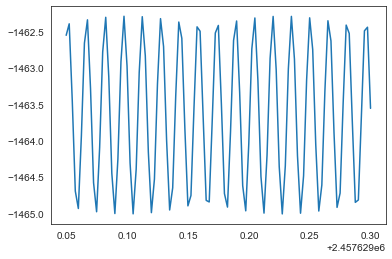

In [18]:
# DS1 benchmark curve:
plt.plot(ds1_time, ds1_value)

(2457629.0497808983, 2457629.0650809556)

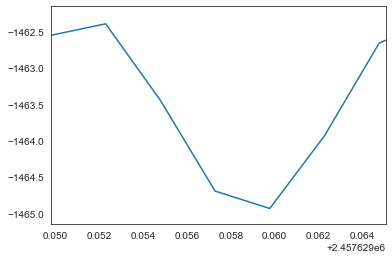

In [19]:
# DS1 benchmark curve - Only 1 period:
plt.plot(ds1_time, ds1_value)
plt.xlim(ds1_time.min(), ds1_time.min()+1/frequency[0])

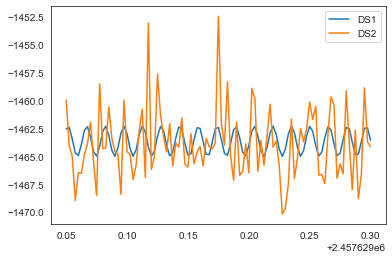

In [20]:
# DS1 and DS2 curves:
plt.plot(ds1_time, ds1_value, label='DS1')
plt.plot(ds1_time, ds2_value, label='DS2')
plt.legend()
plt.show();

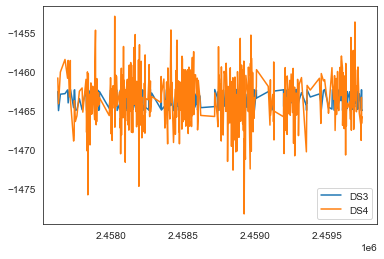

In [21]:
# DS3 and DS4 curves:
plt.plot(ds3_time, ds3_value, label='DS3')
plt.plot(ds3_time, ds4_value, label='DS4')
plt.legend()
plt.show();

#### More elaborated plots

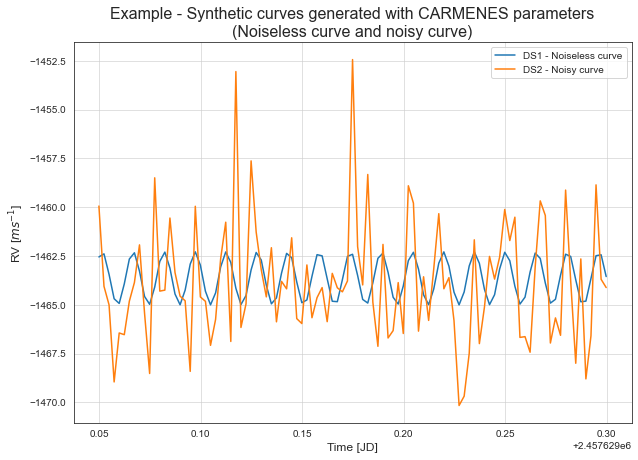

In [22]:
# DS1 and DS2 curves:
plt.figure(figsize=(10,7))
plt.title("Example - Synthetic curves generated with CARMENES parameters\n(Noiseless curve and noisy curve)", fontsize=16)
plt.grid(axis='both', alpha=0.75)
plt.xlabel("Time [JD]", fontsize=12)
plt.ylabel('RV [$ms^{-1}$]', fontsize=12)
sns.lineplot(x=ds1_time.flatten(), y=ds1_value.flatten(), label='DS1 - Noiseless curve')
sns.lineplot(x=ds1_time.flatten(), y=ds2_value.flatten(), label='DS2 - Noisy curve')
plt.savefig(IMAGE_FOLDER + "SyntheticDataset_20_01_Example_Synthetic_curves_CARMENES_DS1_DS2.png", format='png')
plt.show();

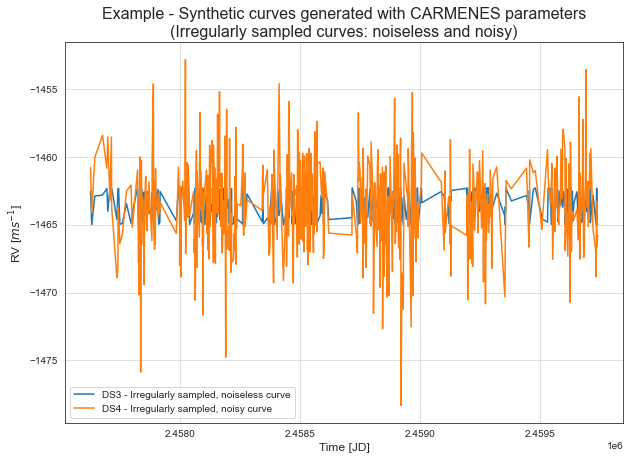

In [23]:
# DS3 and DS4 curves:
plt.figure(figsize=(10,7))
plt.title("Example - Synthetic curves generated with CARMENES parameters\n" \
          "(Irregularly sampled curves: noiseless and noisy)", fontsize=16)
plt.grid(axis='both', alpha=0.75)
plt.xlabel("Time [JD]", fontsize=12)
plt.ylabel('RV [$ms^{-1}$]', fontsize=12)
sns.lineplot(x=ds3_time.flatten(), y=ds3_value.flatten(), label='DS3 - Irregularly sampled, noiseless curve')
sns.lineplot(x=ds3_time.flatten(), y=ds4_value.flatten(), label='DS4 - Irregularly sampled, noisy curve')
plt.savefig(IMAGE_FOLDER + "SyntheticDataset_20_02_Example_Synthetic_curves_CARMENES_DS3_DS4.png", format='png')
plt.show();